In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()

### **Import Training and Testing set**

*We will use SMOTE balanced dataset for the purpose of tunning the hyperparameters* 

In [3]:
train_smote = pd.read_pickle("data/train_smote.pickle")
test = pd.read_pickle("data/test.pickle")

### **Split Attributes and Target Class**

In [4]:
x = train_smote.iloc[:, :-1]
y = train_smote["Class"]

### **Split training and validation set**

In [5]:
from sklearn.model_selection import train_test_split
xtrain, xvalid, ytrain, yvalid = train_test_split(x, y, test_size=0.25, stratify=y,random_state=123)

### **LightGBM**

*It stands for `Light Gradient Boosting machine`. It gives faster training , low memory usage in comparison to other frameworks. 
LightGBM use leaf wise tree growth rather than level wise growth.*

In [6]:
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

### **Tunning Hyperparameter**

*Following hyperparameters are needed to be tuned using optuna.*
1. max_depth
2. subsample
3. learning_rate

In [9]:
def optimize(trial):
    params = {
        "objective": "binary",
        "metric": "auc",
        "max_depth": trial.suggest_int("max_depth", 3, 50),
        "subsample":trial.suggest_float("subsample", 0.5, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
        "num_threads": -1,
        "verbosity":-1      # to remove unnecessary warnings 
    }
    lgbm_train = lightgbm.Dataset(xtrain.to_numpy(), ytrain.to_numpy())
    model_lgbm = lightgbm.train(params, lgbm_train)
    pred_prob = model_lgbm.predict(xvalid.to_numpy())
    v_pred = []
    for prob in pred_prob:
        if prob >=0.5:
            v_pred.append(1)
        else:
            v_pred.append(0)
    v_pred = np.array(v_pred)
    auc = roc_auc_score(yvalid.to_numpy(), v_pred)
    return auc

In [10]:
import optuna
study = optuna.create_study(direction="maximize")
study.optimize(optimize,n_trials=30)

[I 2022-08-21 18:22:28,042] A new study created in memory with name: no-name-6a7f62e4-b9ca-4861-aa4d-51930b3925b2
[I 2022-08-21 18:22:29,619] Trial 0 finished with value: 0.9997092458605876 and parameters: {'max_depth': 31, 'subsample': 0.842105938525934, 'learning_rate': 0.10997923364939254}. Best is trial 0 with value: 0.9997092458605876.
[I 2022-08-21 18:22:31,012] Trial 1 finished with value: 0.9959825936434182 and parameters: {'max_depth': 36, 'subsample': 0.7258201150180046, 'learning_rate': 0.3581766157448885}. Best is trial 0 with value: 0.9997092458605876.
[I 2022-08-21 18:22:32,355] Trial 2 finished with value: 0.9956199240720687 and parameters: {'max_depth': 7, 'subsample': 0.8149059977690132, 'learning_rate': 0.34818863664501826}. Best is trial 0 with value: 0.9997092458605876.
[I 2022-08-21 18:22:33,577] Trial 3 finished with value: 0.9956449448669097 and parameters: {'max_depth': 47, 'subsample': 0.8158740326787493, 'learning_rate': 0.384666772763067}. Best is trial 0 wit

### **Fitting model**

*We implement function that fits the data with specific hyperparameters to the LightGBM model and then 
prints the precision recall for target classes in test set with the confusion matrix of validation and 
test set*

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
def lgbm_fit(train_set):
    xtrain, xvalid, ytrain, yvalid = train_test_split(train_set.iloc[:,:-1].to_numpy(), 
                                                      train_set["Class"].to_numpy(), test_size=0.25, random_state=123)
    lgb = LGBMClassifier(objective="binary",
                        metric="auc",
                        max_depth=15, 
                        subsample=0.5, 
                        learning_rate=0.1, 
                        verbosity = -1)
    lgb.fit(xtrain, ytrain)
    v_pred = lgb.predict(xvalid)
    y_pred = lgb.predict(test.iloc[:,:-1])
    vcm = confusion_matrix(yvalid,v_pred)
    ycm = confusion_matrix(test["Class"], y_pred)
    fig , axes = plt.subplots(1,2)
    fig1 = sns.heatmap(vcm, cmap="Blues", linewidths=0.9, cbar=False, annot=True, fmt ="d",ax=axes[0])
    fig2 = sns.heatmap(ycm, cmap="Blues", linewidths=0.9, cbar=False, annot=True, fmt ="d",ax=axes[1])
    fig1.set(xlabel="Predicted", ylabel="Truth")
    fig1.set_title("Validation")
    fig2.set(xlabel="Predicted", ylabel="Truth")
    fig2.set_title("Test")
    fig.suptitle("LightGBM")
    plt.tight_layout()

### **Undersampling**

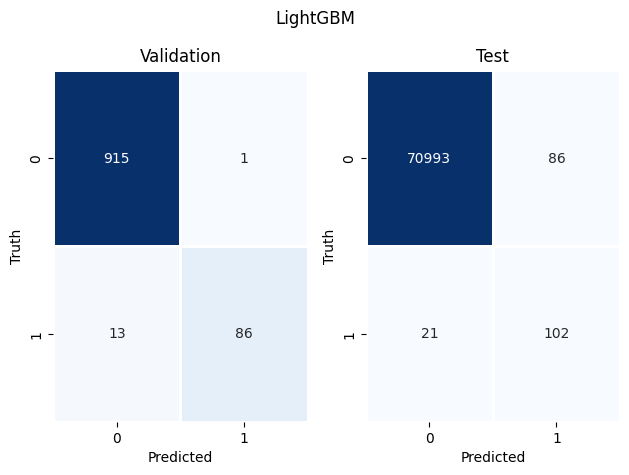

In [19]:
train_under = pd.read_pickle("data/train_under.pickle")
lgbm_fit(train_under)

### **Bootstrap Sampling**

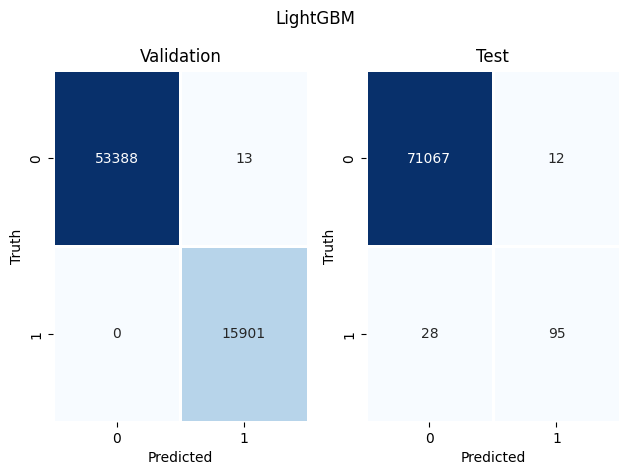

In [20]:
train_over = pd.read_pickle("data/train_over.pickle")
lgbm_fit(train_over)

### **Oversampling with shrinkage**

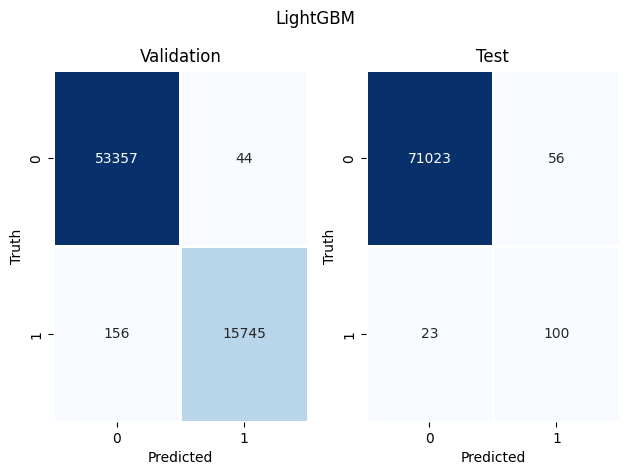

In [21]:
train_over_shrink = pd.read_pickle("data/train_over_shrink.pickle")
lgbm_fit(train_over_shrink)

### **SMOTE**

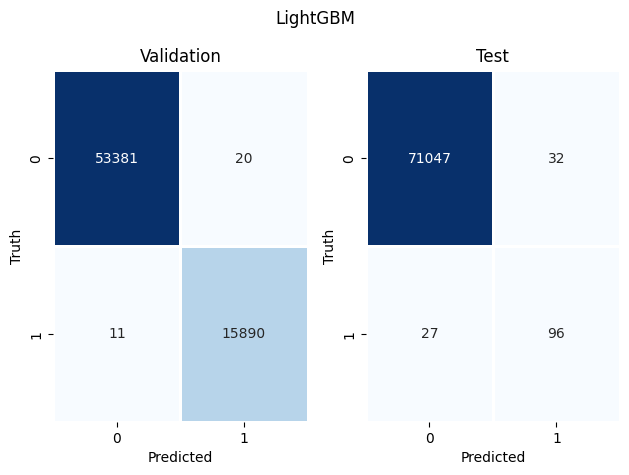

In [22]:
lgbm_fit(train_smote)

### **ADASYN**

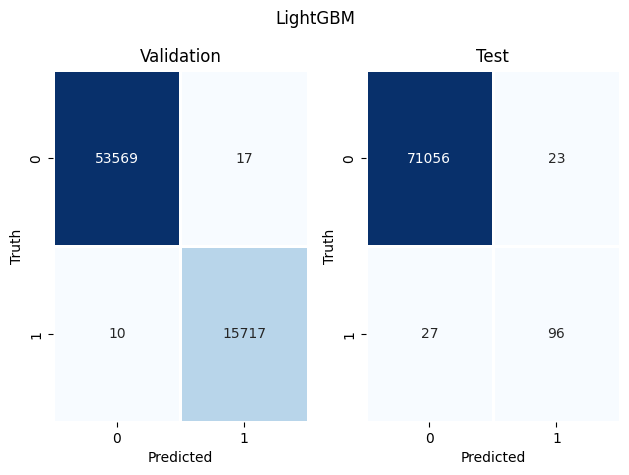

In [23]:
train_adasyn = pd.read_pickle("data/train_adasyn.pickle")
lgbm_fit(train_adasyn)

### **Save Model**

In [24]:
xtrain = train_over_shrink.iloc[:, :-1].to_numpy()
ytrain = train_over_shrink["Class"].to_numpy()

lgb = LGBMClassifier(objective="binary",
                        metric="auc",
                        max_depth=14, 
                        subsample=0.5, 
                        learning_rate=0.1, 
                        verbosity = -1)
lgb.fit(xtrain, ytrain)

LGBMClassifier(max_depth=14, metric='auc', objective='binary', subsample=0.5,
               verbosity=-1)

In [25]:
import joblib
joblib.dump(lgb, "models/lgb.pkl")

['models/lgb.pkl']